<a href="https://colab.research.google.com/github/Sushrut0202/CIIMS/blob/main/AMR_classes_GN_GP_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving AMR data for class wise resistance viz.xlsx to AMR data for class wise resistance viz.xlsx
No Gram or microorganism column found; all rows classified as 'Unknown'.
Gram-positive class totals:
 Aminoglycosides     0
Cephalosporins      0
Fluoroquinolones    0
Glycopeptides       0
Lincosamides        0
Macrolides          0
Nitrofurans         0
Other               0
Oxazolidinones      0
Penicillins         0
Polymyxins          0
Rifamycins          0
Sulfonamides        0
Tetracyclines       0
Trimethoprims       0
dtype: int64
Gram-negative class totals:
 Aminoglycosides     0
Cephalosporins      0
Fluoroquinolones    0
Glycopeptides       0
Lincosamides        0
Macrolides          0
Nitrofurans         0
Other               0
Oxazolidinones      0
Penicillins         0
Polymyxins          0
Rifamycins          0
Sulfonamides        0
Tetracyclines       0
Trimethoprims       0
dtype: int64


/tmp/ipython-input-4070875891.py:223: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, class_grouped.max() * 1.20 if class_grouped.size else 1)
/tmp/ipython-input-4070875891.py:223: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, class_grouped.max() * 1.20 if class_grouped.size else 1)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


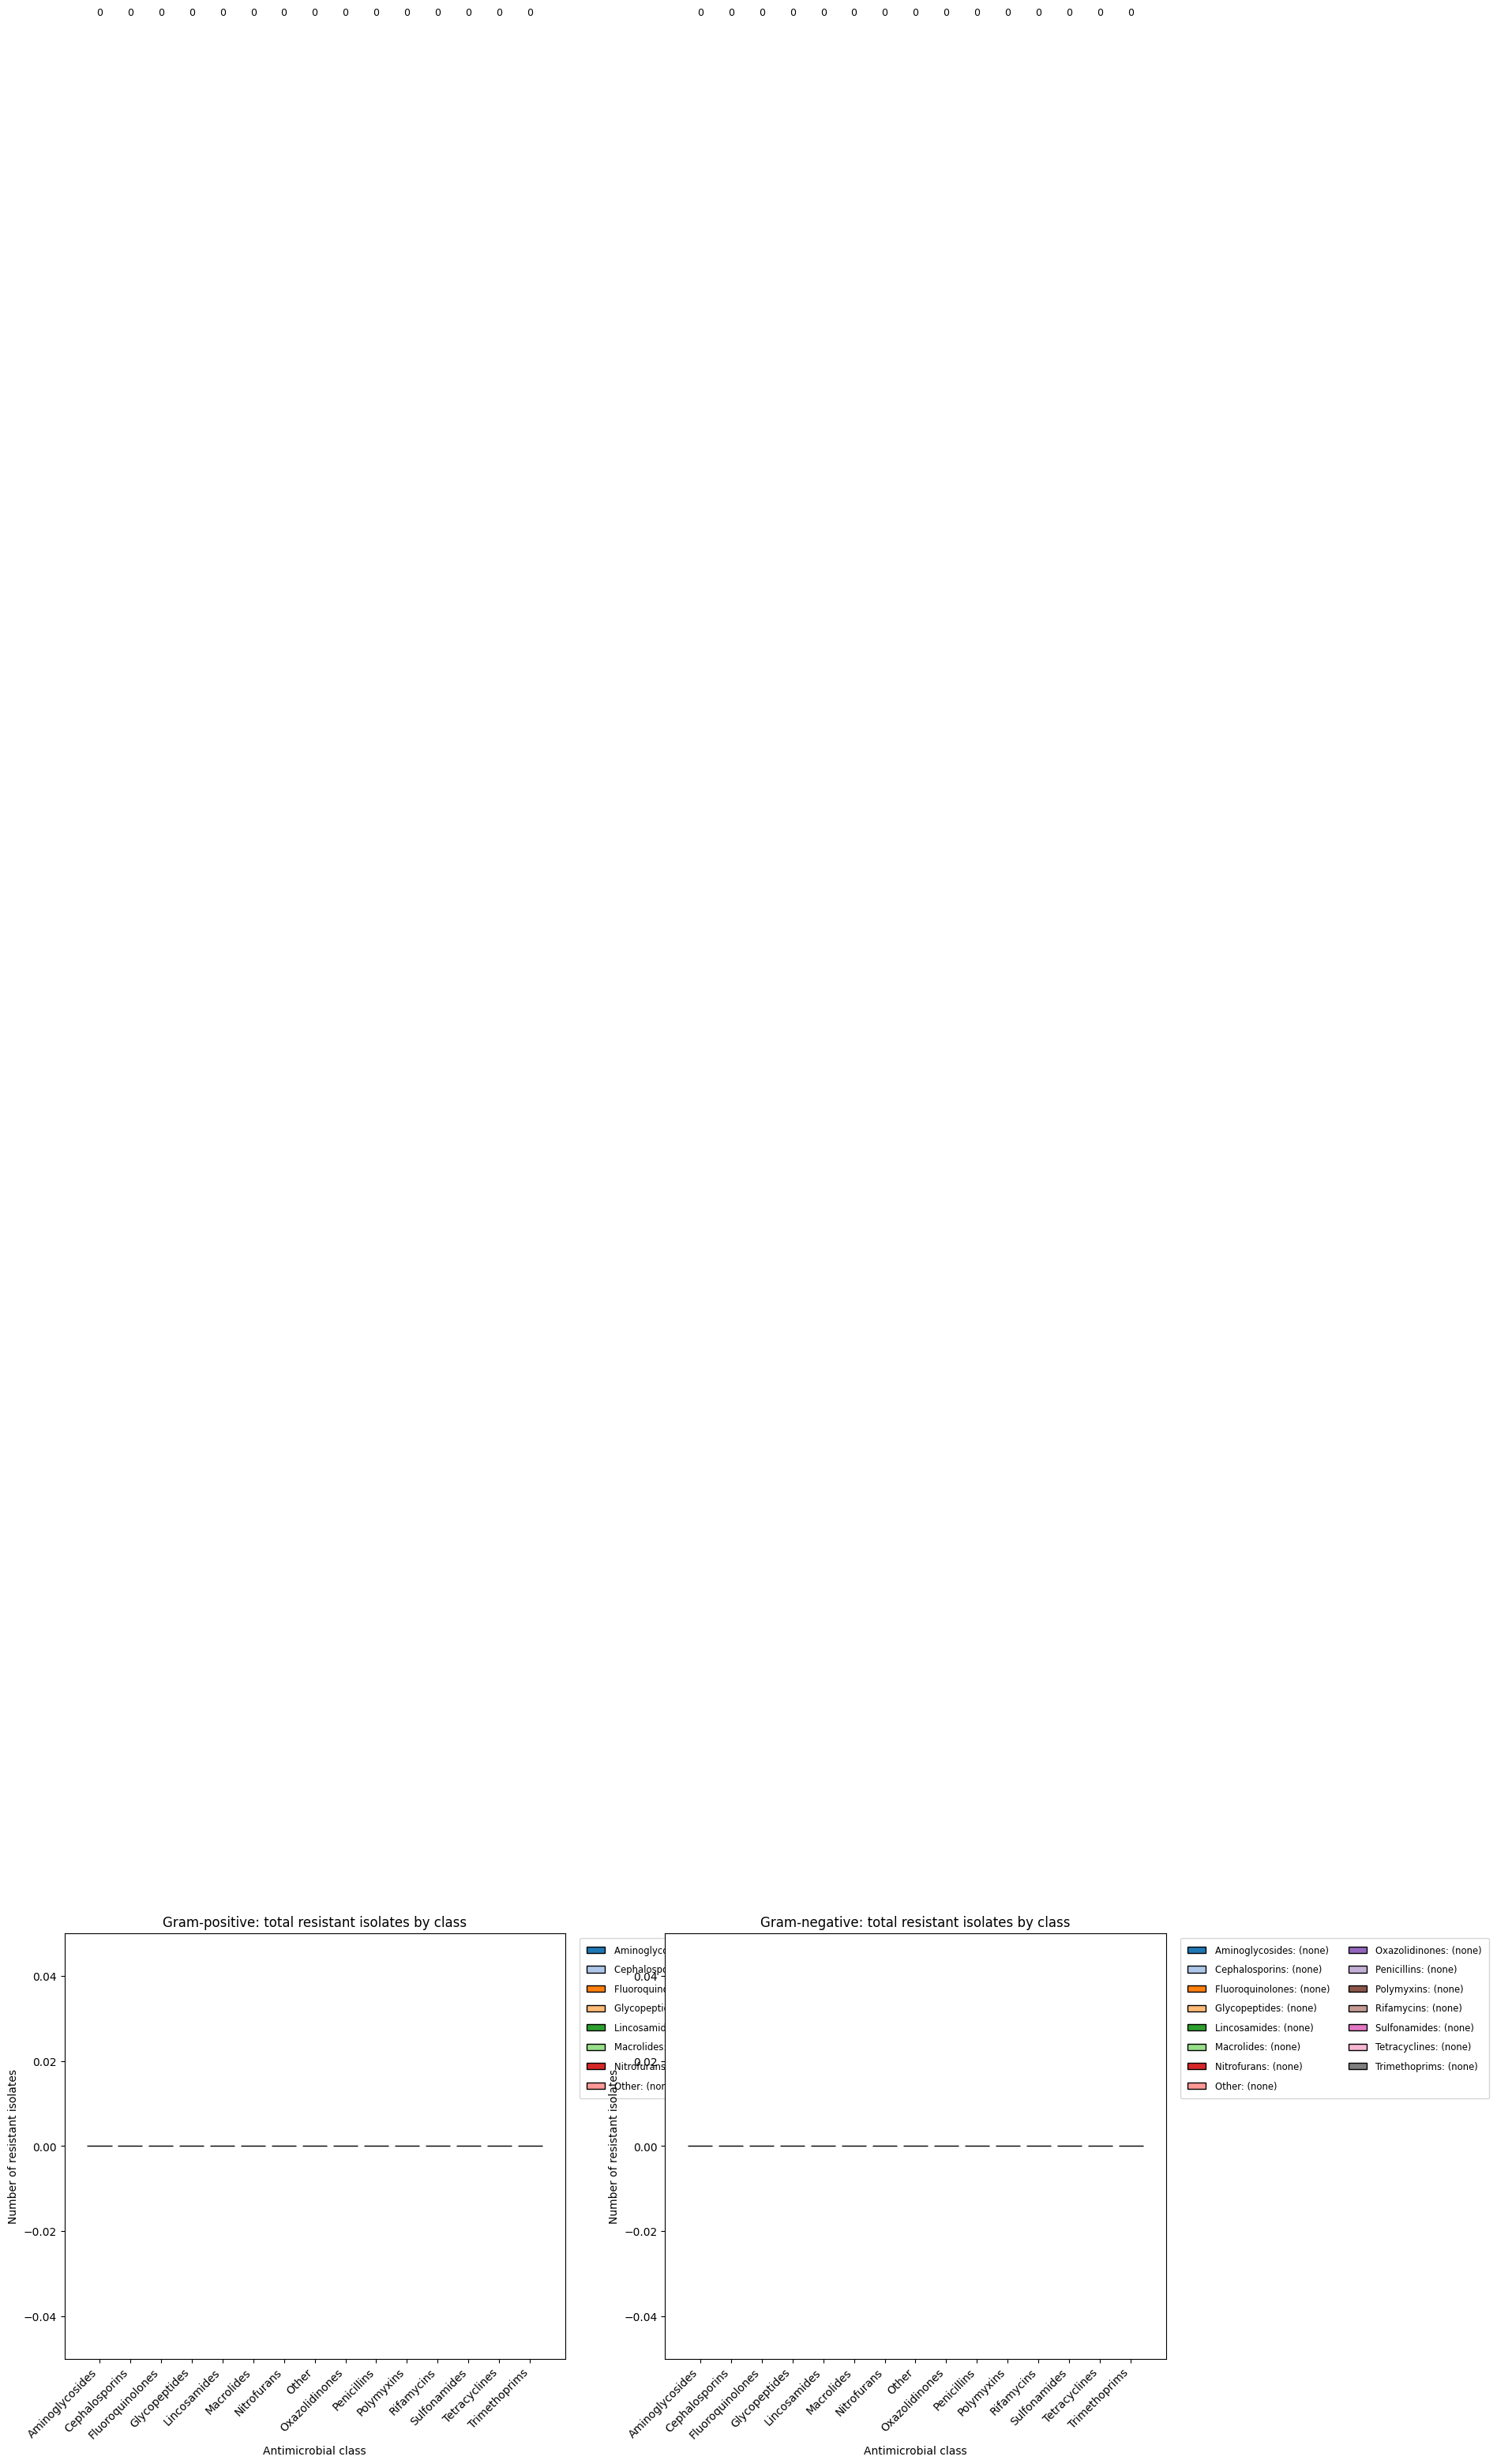

In [1]:
# === Two aggregated class bar plots: Gram-positive and Gram-negative ===
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
import re

# === Read file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === Specify antibiotic column range (adjust if needed) ===
start_idx = 15          # first antibiotic column index
end_idx   = 50          # last antibiotic column index (inclusive)

# === Fix antibiotic headers (if they are in the first row) ===
abx_name_row = df.iloc[0, start_idx:end_idx+1]
new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols
df = df.drop(index=0).reset_index(drop=True)

# === Extract antibiotic columns and clean ===
abx = df.iloc[:, start_idx:end_idx+1]
abx_clean = abx.astype(str).apply(lambda x: x.str.strip().str.upper())

# === Count resistant isolates ("R") per antibiotic for whole dataset (we'll subset later) ===
# Note: we'll compute counts separately for Gram groups below by filtering rows first.

# -------------------------
# 1) Detect Gram information (column) or infer conservatively from microorganism genus
# -------------------------
gram_col = None
for c in ['gram', 'gram_stain', 'GRAM', 'Gram', 'Gram_stain']:
    if c in df.columns:
        gram_col = c
        break

# If no direct Gram column, attempt inference from organism column (best-effort)
mo_col = None
for c in ['mo', 'organism', 'species', 'microorganism', 'bacteria', 'isolates', 'microbe']:
    if c in df.columns:
        mo_col = c
        break

# small conservative genus -> gram mapping for common genera (extend as needed)
GENUS_TO_GRAM = {
    # Gram-negative examples
    'ESCHERICHIA': 'Gram-negative',
    'E.COLI': 'Gram-negative',
    'SALMONELLA': 'Gram-negative',
    'KLEBSIELLA': 'Gram-negative',
    'PSEUDOMONAS': 'Gram-negative',
    'PROTEUS': 'Gram-negative',
    'ACINETOBACTER': 'Gram-negative',
    'NEISSERIA': 'Gram-negative',
    # Gram-positive examples
    'STAPHYLOCOCCUS': 'Gram-positive',
    'STREPTOCOCCUS': 'Gram-positive',
    'ENTEROCOCCUS': 'Gram-positive',
    'BACILLUS': 'Gram-positive',
    'CLOSTRIDIUM': 'Gram-positive',
    # add more genera if you like
}

def infer_gram_from_mo(value):
    if pd.isna(value):
        return None
    s = str(value).upper()
    # Try to extract genus (first token)
    # Common formats: "Escherichia coli", "E. coli", "ESCHERICHIA COLI"
    # Handle initial "E." forms:
    s = s.replace('.', ' ')
    tokens = [t for t in re.split(r'[\s,;()]+', s) if t]
    if not tokens:
        return None
    genus = tokens[0]
    # direct match
    if genus in GENUS_TO_GRAM:
        return GENUS_TO_GRAM[genus]
    # if the genus is like E (single letter) and second token exists (e coli), try combining
    if len(genus) == 1 and len(tokens) > 1:
        combined = genus + '.' + tokens[1]  # e.g., E.COLI
        if combined in GENUS_TO_GRAM:
            return GENUS_TO_GRAM[combined]
    return None

# Build a gram series per row: prefer explicit column, else inference, else 'Unknown'
if gram_col:
    gram_series = df[gram_col].astype(str).str.strip().str.capitalize().replace(
        {'Gram-negative': 'Gram-negative', 'Gram-positive': 'Gram-positive'})
    # Normalise possible values like 'POS', 'NEG', 'P', 'N' to full words if present
    gram_series = gram_series.replace({
        'POS': 'Gram-positive', 'P': 'Gram-positive', 'POSITIVE': 'Gram-positive',
        'NEG': 'Gram-negative', 'N': 'Gram-negative', 'NEGATIVE': 'Gram-negative'
    })
else:
    gram_series = pd.Series([None]*len(df), index=df.index)
    if mo_col:
        for idx, val in df[mo_col].iteritems():
            g = infer_gram_from_mo(val)
            gram_series.at[idx] = g
    # fill unknown as 'Unknown'
    gram_series = gram_series.fillna('Unknown')

# Summarise detection method
if gram_col:
    print(f"Using Gram column: {gram_col}")
else:
    if mo_col:
        print(f"No explicit Gram column; inferred Gram from '{mo_col}' for many rows (best-effort). Unknowns may remain.")
    else:
        print("No Gram or microorganism column found; all rows classified as 'Unknown'.")

# -------------------------
# 2) Antibiotic -> class mapping (keyword-based)
# -------------------------
ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides", "AMK": "Aminoglycosides", "GENTAMICIN": "Aminoglycosides", "GEN": "Aminoglycosides",
    "TOBRAMYCIN": "Aminoglycosides", "TOB": "Aminoglycosides", "KANAMYCIN": "Aminoglycosides", "KAN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems", "IPM": "Carbapenems", "MEROPENEM": "Carbapenems", "MEM": "Carbapenems", "ERTAPENEM": "Carbapenems",
    "CEFTRIAXONE": "Cephalosporins", "CEFOTAXIME": "Cephalosporins", "CEFTAZIDIME": "Cephalosporins", "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins", "CEFAZOLIN": "Cephalosporins",
    "CIPROFLOXACIN": "Fluoroquinolones", "CIPRO": "Fluoroquinolones", "LEVOFLOXACIN": "Fluoroquinolones",
    "AZITHROMYCIN": "Macrolides", "ERYTHROMYCIN": "Macrolides", "CLARITHROMYCIN": "Macrolides",
    "PIPERACILLIN": "Penicillins", "AMPICILLIN": "Penicillins", "AMOXICILLIN": "Penicillins",
    "PIPERACILLIN/TAZOBACTAM": "Penicillins (with inhibitor)", "TZP": "Penicillins (with inhibitor)",
    "VANCOMYCIN": "Glycopeptides", "VAN": "Glycopeptides", "TEICOPLANIN": "Glycopeptides",
    "COLISTIN": "Polymyxins", "COL": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines", "DOXYCYCLINE": "Tetracyclines", "TIGECYCLINE": "Tetracyclines",
    "CLINDAMYCIN": "Lincosamides", "CLI": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins", "RIFAMPIN": "Rifamycins",
    "CHLORAMPHENICOL": "Phenicols",
    "SULFAMETHOXAZOLE": "Sulfonamides", "TRIMETHOPRIM": "Trimethoprims", "CO-TRIMOXAZOLE": "Sulfonamides/Trimethoprim",
    "SXT": "Sulfonamides/Trimethoprim", "TMP-SMX": "Sulfonamides/Trimethoprim",
    "AZTREONAM": "Monobactams",
}

def assign_class_by_keywords(ab_name):
    if pd.isna(ab_name):
        return "Unknown"
    name = str(ab_name).upper()
    for key, cls in ABX_KEYWORD_TO_CLASS.items():
        if key in name:
            return cls
    # fallback heuristics
    tokens = [t for t in re.split(r"[ \-/()]+", name) if t]
    for t in tokens:
        for key, cls in ABX_KEYWORD_TO_CLASS.items():
            if key == t:
                return cls
    return "Other"

# map antibiotics (full column names) to classes
# Note: resistance_counts need to be computed per Gram group; we'll compute for each subset
abx_full_names = abx_clean.columns.tolist()
abx_to_class = pd.Series(index=abx_full_names, dtype="object")
for col in abx_full_names:
    abx_to_class.loc[col] = assign_class_by_keywords(col)

# -------------------------
# 3) Helper: compute aggregated class counts for a filtered dataframe
# -------------------------
def aggregated_class_counts_for_subset(df_subset, abx_clean_subset):
    # df_subset has same row ordering as abx_clean_subset
    # count 'R' per antibiotic column
    counts = (abx_clean_subset == "R").sum()
    counts = counts.reindex(abx_full_names).fillna(0).astype(int)
    # map to classes
    class_grouped = counts.groupby(abx_to_class).sum()
    class_grouped = class_grouped.sort_values(ascending=False)
    # also build class->list of antibiotics present (non-zero)
    counts_df = counts.to_frame(name="resistant_count").reset_index().rename(columns={"index":"antibiotic"})
    counts_df["class"] = counts_df["antibiotic"].map(abx_to_class)
    class_to_abx_present = {}
    for cls, g in counts_df.groupby("class"):
        present = g.loc[g["resistant_count"] > 0, "antibiotic"].tolist()
        class_to_abx_present[cls] = sorted(present)
    return class_grouped, class_to_abx_present

# Build subsets
mask_gp = gram_series == 'Gram-positive'
mask_gn = gram_series == 'Gram-negative'

# create aligned abx_clean subsets
abx_clean_rows = abx_clean.reset_index(drop=True)
df_rows = df.reset_index(drop=True)

abx_gp = abx_clean_rows[mask_gp.values]
abx_gn = abx_clean_rows[mask_gn.values]

class_gp, class_to_abx_gp = aggregated_class_counts_for_subset(df_rows[mask_gp.values], abx_gp)
class_gn, class_to_abx_gn = aggregated_class_counts_for_subset(df_rows[mask_gn.values], abx_gn)

print("Gram-positive class totals:\n", class_gp)
print("Gram-negative class totals:\n", class_gn)

# -------------------------
# 4) Plot side-by-side vertical bar charts with legends listing antibiotics per class
# -------------------------
def plot_class_bars_with_legend(class_grouped, class_to_abx, title, ax, fig_width=16):
    classes = class_grouped.index.tolist()
    cmap = plt.get_cmap("tab20")
    class_colors = {cls: cmap(i % 20) for i, cls in enumerate(classes)}
    x = np.arange(len(classes))
    bars = ax.bar(x, class_grouped.values, color=[class_colors[c] for c in classes], edgecolor='black')

    # numeric labels above bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                h + (class_grouped.max() * 0.02 + 0.5),
                str(int(h)),
                ha='center', va='bottom', fontsize=9)

    # headroom
    ax.set_ylim(0, class_grouped.max() * 1.20 if class_grouped.size else 1)

    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_xlabel("Antimicrobial class")
    ax.set_ylabel("Number of resistant isolates")
    ax.set_title(title)

    # legend entries: class -> antibiotics (wrap)
    legend_handles = []
    for cls in classes:
        ab_list = class_to_abx.get(cls, [])
        if len(ab_list) == 0:
            label = f"{cls}: (none)"
        else:
            joined = ", ".join(ab_list)
            wrapped = textwrap.fill(joined, width=60)
            label = f"{cls}: {wrapped}"
        patch = mpatches.Patch(facecolor=class_colors[cls], edgecolor='black', label=label)
        legend_handles.append(patch)

    # show legend at right, spread in two columns if many entries
    ncol = 1 if len(legend_handles) <= 6 else 2
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize='small', frameon=True, labelspacing=1.0, borderpad=0.8, handletextpad=1.0, ncol=ncol)

# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), constrained_layout=True)

plot_class_bars_with_legend(class_gp, class_to_abx_gp, "Gram-positive: total resistant isolates by class", axes[0])
plot_class_bars_with_legend(class_gn, class_to_abx_gn, "Gram-negative: total resistant isolates by class", axes[1])

plt.show()


In [2]:
list(abx_clean.columns)


['Amoxycillin/Clavulanic acid',
 'Piperacillin/Tazobactum',
 'Cefuroxime',
 'Cefuroxime Axetil',
 'Ceftriaxone',
 'Cefoperazone/Sulbactum',
 'Cefepime',
 'Entrapenum',
 'Imipenum',
 'Metropenem',
 'Amikacin',
 'Gentamicin',
 'Ciprofloxacin',
 'Tigecycline',
 'Fosfomycin',
 'Colistin',
 'Trimethoprim/Sulfmaethozole',
 'Beta-lactamase',
 'Cefoxitin',
 'Benzylpenicillin',
 'Oxacillin',
 'Gentamicin High Level (synergy)',
 'Gentamycin',
 'Levofloxacin',
 'Induciable Clindamycin Resistance',
 'Erythromycin',
 'Clindamycin',
 'Linezolid',
 'Daptomycin',
 'Teicoplanin',
 'Vanomycin',
 'Tetracyclin',
 'Nitrofurantoin',
 'Rifampicin',
 'Trimethoprim/Sulfamethoxazole',
 'Cefoxitin Screen']

In [3]:
print(resistance_counts.index.tolist())


NameError: name 'resistance_counts' is not defined

In [4]:
# === FINAL MULTI-CATEGORY ANTIBIOTIC RESISTANCE PLOTS ===

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap

# === Load file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === Antibiotic column range (same as your original script) ===
start_idx = 15
end_idx   = 50

# === Fix antibiotic header row ===
abx_name_row = df.iloc[0, start_idx:end_idx+1]
new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols
df = df.drop(index=0).reset_index(drop=True)

# === Extract antibiotic columns ===
abx = df.iloc[:, start_idx:end_idx+1]
abx_clean = abx.astype(str).apply(lambda x: x.str.strip().str.upper())

# === Remove non-antibiotic tests ===
cols_to_drop = [
    "BETA-LACTAMASE",
    "INDUCIABLE CLINDAMYCIN RESISTANCE"
]
abx_clean = abx_clean[[c for c in abx_clean.columns if c.upper() not in cols_to_drop]]

# === Final antibiotic list (all uppercase for matching) ===
abx_list = abx_clean.columns.tolist()

# === Classification of your antibiotics (final) ===

GRAM_POS = [
    "BENZYLPENICILLIN",
    "OXACILLIN",
    "ERYTHROMYCIN",
    "CLINDAMYCIN",
    "LINEZOLID",
    "DAPTOMYCIN",
    "TEICOPLANIN",
    "VANOMYCIN",
    "RIFAMPICIN",
    "GENTAMICIN HIGH LEVEL (SYNERGY)",
]

GRAM_NEG = [
    "AMIKACIN",
    "GENTAMICIN",
    "GENTAMYCIN",
    "COLISTIN",
]

BROAD = [
    "AMOXYCILLIN/CLAVULANIC ACID",
    "PIPERACILLIN/TAZOBACTUM",
    "CEFTRIAXONE",
    "CEFEPIME",
    "CEFOPERAZONE/SULBACTUM",
    "CEFUROXIME",
    "CEFUROXIME AXETIL",
    "CEFOXITIN",
    "CEFOXITIN SCREEN",
    "ENTRAPENUM",
    "IMIPENUM",
    "METROPENEM",
    "CIPROFLOXACIN",
    "LEVOFLOXACIN",
    "TIGECYCLINE",
    "FOSFOMYCIN",
    "TETRACYCLIN",
    "NITROFURANTOIN",
    "TRIMETHOPRIM/SULFMAETHOZOLE",
    "TRIMETHOPRIM/SULFAMETHOXAZOLE",
]

# Uppercase for matching
GRAM_POS = [g.upper() for g in GRAM_POS]
GRAM_NEG = [g.upper() for g in GRAM_NEG]
BROAD    = [g.upper() for g in BROAD]

# === Count R values per antibiotic ===
res_counts = (abx_clean == "R").sum()

# === Helper: filter counts by category ===
def filter_category(cat_list):
    selected = {ab: res_counts[ab] for ab in res_counts.index if ab in cat_list}
    if len(selected) == 0:
        return pd.Series(dtype=int)
    return pd.Series(selected).sort_values(ascending=False)

res_gp = filter_category(GRAM_POS)
res_gn = filter_category(GRAM_NEG)
res_bs = filter_category(BROAD)

# === Plot helper ===
def plot_category(data, title):
    if data.empty:
        print(f"No antibiotics found for: {title}")
        return

    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(len(data))
    bars = ax.bar(x, data.values, color=plt.cm.tab20.colors[:len(data)], edgecolor='black')

    # numeric labels
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                h + max(1, h*0.05),
                str(int(h)),
                ha='center', va='bottom', fontsize=10)

    # headroom
    ax.set_ylim(0, data.max() * 1.25)

    # x labels
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_ylabel("Number of resistant isolates")
    ax.set_title(title)

    # legend showing antibiotics
    legend_handles = []
    for i, ab in enumerate(data.index):
        patch = mpatches.Patch(facecolor=plt.cm.tab20.colors[i], edgecolor='black', label=ab)
        legend_handles.append(patch)

    ax.legend(handles=legend_handles,
              bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize='small', frameon=True,
              ncol=1, labelspacing=1.1, borderpad=1.2)

    plt.tight_layout()
    plt.show()

# === Produce the three plots ===
plot_category(res_gp, "Gram-Positive Antibiotic Resistance (R Counts)")
plot_category(res_gn, "Gram-Negative Antibiotic Resistance (R Counts)")
plot_category(res_bs, "Broad-Spectrum Antibiotic Resistance (R Counts)")


Saving AMR data for class wise resistance viz.xlsx to AMR data for class wise resistance viz (1).xlsx
No antibiotics found for: Gram-Positive Antibiotic Resistance (R Counts)
No antibiotics found for: Gram-Negative Antibiotic Resistance (R Counts)
No antibiotics found for: Broad-Spectrum Antibiotic Resistance (R Counts)


In [1]:
# === FINAL MULTI-CATEGORY ANTIBIOTIC RESISTANCE PLOTS ===

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap

# === Load file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === Antibiotic column range (same as your original script) ===
start_idx = 15
end_idx   = 50

# === Fix antibiotic header row ===
abx_name_row = df.iloc[0, start_idx:end_idx+1]
new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols
df = df.drop(index=0).reset_index(drop=True)

# === Extract antibiotic columns ===
abx = df.iloc[:, start_idx:end_idx+1]
abx_clean = abx.astype(str).apply(lambda x: x.str.strip().str.upper())

# === Remove non-antibiotic tests ===
cols_to_drop = [
    "BETA-LACTAMASE",
    "INDUCIABLE CLINDAMYCIN RESISTANCE"
]
abx_clean = abx_clean[[c for c in abx_clean.columns if c.upper() not in cols_to_drop]]

# === Final antibiotic list (all uppercase for matching) ===
# === Build uppercase mapping for matching ===
original_cols = abx_clean.columns.tolist()
upper_cols = [c.upper() for c in original_cols]

# mapping: UPPERCASE_NAME → ORIGINAL_NAME
upper_to_original = dict(zip(upper_cols, original_cols))

# Use uppercase for resistance counting
res_counts = (abx_clean == "R").sum()
res_counts.index = upper_cols  # make index uppercase



# === Classification of your antibiotics (final) ===

GRAM_POS = [
    "BENZYLPENICILLIN",
    "OXACILLIN",
    "ERYTHROMYCIN",
    "CLINDAMYCIN",
    "LINEZOLID",
    "DAPTOMYCIN",
    "TEICOPLANIN",
    "VANOMYCIN",
    "RIFAMPICIN",
    "GENTAMICIN HIGH LEVEL (SYNERGY)",
]

GRAM_NEG = [
    "AMIKACIN",
    "GENTAMICIN",
    "GENTAMYCIN",
    "COLISTIN",
]

BROAD = [
    "AMOXYCILLIN/CLAVULANIC ACID",
    "PIPERACILLIN/TAZOBACTUM",
    "CEFTRIAXONE",
    "CEFEPIME",
    "CEFOPERAZONE/SULBACTUM",
    "CEFUROXIME",
    "CEFUROXIME AXETIL",
    "CEFOXITIN",
    "CEFOXITIN SCREEN",
    "ENTRAPENUM",
    "IMIPENUM",
    "METROPENEM",
    "CIPROFLOXACIN",
    "LEVOFLOXACIN",
    "TIGECYCLINE",
    "FOSFOMYCIN",
    "TETRACYCLIN",
    "NITROFURANTOIN",
    "TRIMETHOPRIM/SULFMAETHOZOLE",
    "TRIMETHOPRIM/SULFAMETHOXAZOLE",
]

# Uppercase for matching
GRAM_POS = [g.upper() for g in GRAM_POS]
GRAM_NEG = [g.upper() for g in GRAM_NEG]
BROAD    = [g.upper() for g in BROAD]

# === Count R values per antibiotic ===
res_counts = (abx_clean == "R").sum()

# === Helper: filter counts by category ===
def filter_category(cat_list):
    selected = {upper_to_original[ab]: int(res_counts[ab])
                for ab in res_counts.index if ab in cat_list}
    if len(selected) == 0:
        return pd.Series(dtype=int)
    return pd.Series(selected).sort_values(ascending=False)


res_gp = filter_category(GRAM_POS)
res_gn = filter_category(GRAM_NEG)
res_bs = filter_category(BROAD)

# === Plot helper ===
def plot_category(data, title):
    if data.empty:
        print(f"No antibiotics found for: {title}")
        return

    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(len(data))
    bars = ax.bar(x, data.values, color=plt.cm.tab20.colors[:len(data)], edgecolor='black')

    # numeric labels
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                h + max(1, h*0.05),
                str(int(h)),
                ha='center', va='bottom', fontsize=10)

    # headroom
    ax.set_ylim(0, data.max() * 1.25)

    # x labels
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_ylabel("Number of resistant isolates")
    ax.set_title(title)

    # legend showing antibiotics
    legend_handles = []
    for i, ab in enumerate(data.index):
        patch = mpatches.Patch(facecolor=plt.cm.tab20.colors[i], edgecolor='black', label=ab)
        legend_handles.append(patch)

    ax.legend(handles=legend_handles,
              bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize='small', frameon=True,
              ncol=1, labelspacing=1.1, borderpad=1.2)

    plt.tight_layout()
    plt.show()

# === Produce the three plots ===
plot_category(res_gp, "Gram-Positive Antibiotic Resistance (R Counts)")
plot_category(res_gn, "Gram-Negative Antibiotic Resistance (R Counts)")
plot_category(res_bs, "Broad-Spectrum Antibiotic Resistance (R Counts)")


KeyboardInterrupt: 

In [2]:
# === Robust final script: classify antibiotics as GP / GN / Broad and plot ===
# Paste & run in Colab; upload your Excel file when prompted.

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap

# === Load file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === Antibiotic column header repair (same method you used) ===
start_idx = 15
end_idx   = 50

abx_name_row = df.iloc[0, start_idx:end_idx+1]
new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols
df = df.drop(index=0).reset_index(drop=True)

# === Extract antibiotic columns and clean string values (but KEEP original column names) ===
abx = df.iloc[:, start_idx:end_idx+1]
abx_clean = abx.astype(str).apply(lambda x: x.str.strip())  # keep original case for display

# === Drop known non-antibiotic test columns (Vitek 2 tests) ===
non_abx_upper = {"BETA-LACTAMASE", "INDUCIABLE CLINDAMYCIN RESISTANCE"}
cols_upper = [c.upper() for c in abx_clean.columns]
cols_to_keep = [orig for orig, up in zip(abx_clean.columns, cols_upper) if up not in non_abx_upper]
abx_clean = abx_clean[cols_to_keep]

# === Build uppercase mapping for matching, with small alias/typo corrections ===
original_cols = abx_clean.columns.tolist()
upper_cols_raw = [c.upper() for c in original_cols]

# common corrections for observed typos / variants (LEFT side = observed UPPER, RIGHT side = canonical UPPER)
CORRECTIONS = {
    "ENTRAPENUM": "ERTAPENEM",         # Entrapenem -> Ertapenem
    "ENTRAPENUM": "ERTAPENEM",
    "METROPENEM": "MEROPENEM",         # Metropenem -> Meropenem
    "IMIPENUM": "IMIPENEM",            # Imipenum -> Imipenem (if present)
    "VANOMYCIN": "VANCOMYCIN",         # Vanomycin -> Vancomycin
    "GENTAMYCIN HIGH LEVEL (SYNERGY)": "GENTAMICIN HIGH LEVEL (SYNERGY)",
    "GENTAMYCIN HIGH-LEVEL (SYNERGY)": "GENTAMICIN HIGH LEVEL (SYNERGY)",
    "GENTAMYCINHIG HLEVEL (SYNERGY)": "GENTAMICIN HIGH LEVEL (SYNERGY)",
    "GENTAMYCIN": "GENTAMICIN",
    "GENTAMYCIN": "GENTAMICIN",
    "GENTAMYcin".upper(): "GENTAMICIN", # fallback if weird capitalization
    "GENTAMYCIN": "GENTAMICIN",
    "GENTAMYCIN": "GENTAMICIN",
    # Trimethoprim misspellings:
    "TRIMETHOPRIM/SULFMAETHOZOLE": "TRIMETHOPRIM/SULFAMETHOXAZOLE",
    "TRIMETHOPRIM/SULFMAETHOZOLE".upper(): "TRIMETHOPRIM/SULFAMETHOXAZOLE",
    # Amoxycillin variant
    "AMOXYCILLIN/CLAVULANIC ACID": "AMOXYCILLIN/CLAVULANIC ACID",
    "AMOXICILLIN/CLAVULANIC ACID": "AMOXYCILLIN/CLAVULANIC ACID",
    # Piperacillin variant
    "PIPERACILLIN/TAZOBACTUM": "PIPERACILLIN/TAZOBACTUM",
    # Cefoxitin screen handled as CEFOXITIN SCREEN
    # Add any other observed typos here as needed
}

def normalize_upper(u):
    u2 = u.strip().upper()
    if u2 in CORRECTIONS:
        return CORRECTIONS[u2]
    # also some tiny normalisations:
    u2 = u2.replace("–", "-")  # en-dash
    u2 = u2.replace("—", "-")
    u2 = u2.replace("  ", " ")
    return CORRECTIONS.get(u2, u2)

upper_cols = [normalize_upper(u) for u in upper_cols_raw]

# mapping uppercase -> original
upper_to_original = {}
for up, orig, upraw in zip(upper_cols, original_cols, upper_cols_raw):
    upper_to_original[up] = orig

# === Compute resistance counts and put index in normalized uppercase form ===
# counts computed from cleaned values (make them uppercase for comparison)
abx_values_upper = abx_clean.apply(lambda col: col.str.strip().str.upper())
res_counts = (abx_values_upper == "R").sum()
# res_counts currently indexed by original names; convert to normalized uppercase index
res_counts_upper = pd.Series(index=[normalize_upper(c.upper()) for c in res_counts.index],
                             data=res_counts.values,
                             dtype=int)

# === Define final category canonical UPPER names (must match normalized uppercase keys) ===
GRAM_POS = [
    "BENZYLPENICILLIN",
    "OXACILLIN",
    "ERYTHROMYCIN",
    "CLINDAMYCIN",
    "LINEZOLID",
    "DAPTOMYCIN",
    "TEICOPLANIN",
    "VANCOMYCIN",
    "RIFAMPICIN",
    "GENTAMICIN HIGH LEVEL (SYNERGY)",
]

GRAM_NEG = [
    "AMIKACIN",
    "GENTAMICIN",
    "COLISTIN",
]

BROAD = [
    "AMOXYCILLIN/CLAVULANIC ACID",
    "PIPERACILLIN/TAZOBACTUM",
    "CEFTRIAXONE",
    "CEFEPIME",
    "CEFOPERAZONE/SULBACTUM",
    "CEFUROXIME",
    "CEFUROXIME AXETIL",
    "CEFOXITIN",
    "CEFOXITIN SCREEN",
    "ERTAPENEM",
    "IMIPENEM",
    "MEROPENEM",
    "CIPROFLOXACIN",
    "LEVOFLOXACIN",
    "TIGECYCLINE",
    "FOSFOMYCIN",
    "TETRACYCLIN",
    "NITROFURANTOIN",
    "TRIMETHOPRIM/SULFAMETHOXAZOLE",
]

# Map alternative canonical names used in CORRECTIONS to these canonical names:
ALIASES = {
    "ENTRAPENUM": "ERTAPENEM",
    "METROPENEM": "MEROPENEM",
    "VANOMYCIN": "VANCOMYCIN",
    # If other alias -> canonical needed, add here
}
# Apply aliasing to category lists (ensures presence if typo normalized)
GRAM_POS = [ALIASES.get(x, x) for x in GRAM_POS]
GRAM_NEG = [ALIASES.get(x, x) for x in GRAM_NEG]
BROAD    = [ALIASES.get(x, x) for x in BROAD]

# === Helper: get series of (original name -> count) for a category ===
def filter_category(cat_list):
    # find intersection between normalized res_counts index and cat_list
    matched = {up: int(res_counts_upper.get(up, 0)) for up in res_counts_upper.index if up in cat_list}
    if not matched:
        return pd.Series(dtype=int)
    # convert keys back to original display names using upper_to_original mapping
    mapped = {}
    for up, cnt in matched.items():
        original_name = upper_to_original.get(up, None)
        if original_name is None:
            # fallback: display the uppercase form if we don't have mapping
            original_name = up
        mapped[original_name] = cnt
    return pd.Series(mapped).sort_values(ascending=False)

# === Build category results ===
res_gp = filter_category(GRAM_POS)
res_gn = filter_category(GRAM_NEG)
res_bs = filter_category(BROAD)

# === Print diagnostics: what was found and what was unmatched ===
print("\n=== Diagnostics ===")
print(f"Total antibiotic columns processed: {len(original_cols)}")
print("Matched columns per category:")
print(f"  Gram-positive: {len(res_gp)}")
print(f"  Gram-negative: {len(res_gn)}")
print(f"  Broad-spectrum: {len(res_bs)}")

# Which normalized columns existed but were not assigned to any category:
assigned_upper = set()
for series in (res_gp, res_gn, res_bs):
    assigned_upper.update([normalize_upper(s.upper()) for s in series.index.tolist()])

all_upper_from_file = set(upper_cols)
unmatched_upper = sorted([u for u in all_upper_from_file if u not in assigned_upper])
unmatched_original = [upper_to_original.get(u, u) for u in unmatched_upper]

print("\nUnmatched antibiotic columns (not assigned to GP/GN/Broad).")
print("If this list contains real antibiotics you want included, reply with the exact names and target group.")
for orig in unmatched_original:
    print(" -", orig)

# === Plot helper function (same look & feel as before) ===
def plot_category(data, title):
    if data.empty:
        print(f"\nNo antibiotics found for: {title}")
        return

    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(len(data))
    # use up to len(data) colours from a qualitative cmap (cycle if needed)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(len(data))]
    bars = ax.bar(x, data.values, color=colors, edgecolor='black')

    # numeric labels above bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                h + max(1, data.max() * 0.02),
                str(int(h)),
                ha='center', va='bottom', fontsize=10)

    ax.set_ylim(0, data.max() * 1.25)
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Number of resistant isolates")

    # legend with one entry per antibiotic (colour matched)
    legend_handles = []
    for i, ab in enumerate(data.index):
        patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', label=ab)
        legend_handles.append(patch)

    ncol = 1 if len(legend_handles) <= 8 else 2
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize='small', frameon=True, ncol=ncol, labelspacing=1.0, borderpad=0.8)

    plt.tight_layout()
    plt.show()

# === Plot the three categories ===
plot_category(res_gp, "Gram-Positive Antibiotic Resistance (R Counts)")
plot_category(res_gn, "Gram-Negative Antibiotic Resistance (R Counts)")
plot_category(res_bs, "Broad-Spectrum Antibiotic Resistance (R Counts)")


Saving AMR data for class wise resistance viz_updated (10-12-2025).xlsx to AMR data for class wise resistance viz_updated (10-12-2025).xlsx


TypeError: cannot convert the series to <class 'int'>

Saving AMR data for class wise resistance viz_updated (10-12-2025).xlsx to AMR data for class wise resistance viz_updated (10-12-2025) (1).xlsx

=== Diagnostics ===
Total antibiotic columns processed: 34
Matched columns per category:
  Gram-positive: 10
  Gram-negative: 3
  Broad-spectrum: 19

Unmatched antibiotic columns (not assigned to GP/GN/Broad).
 - Gentamycin


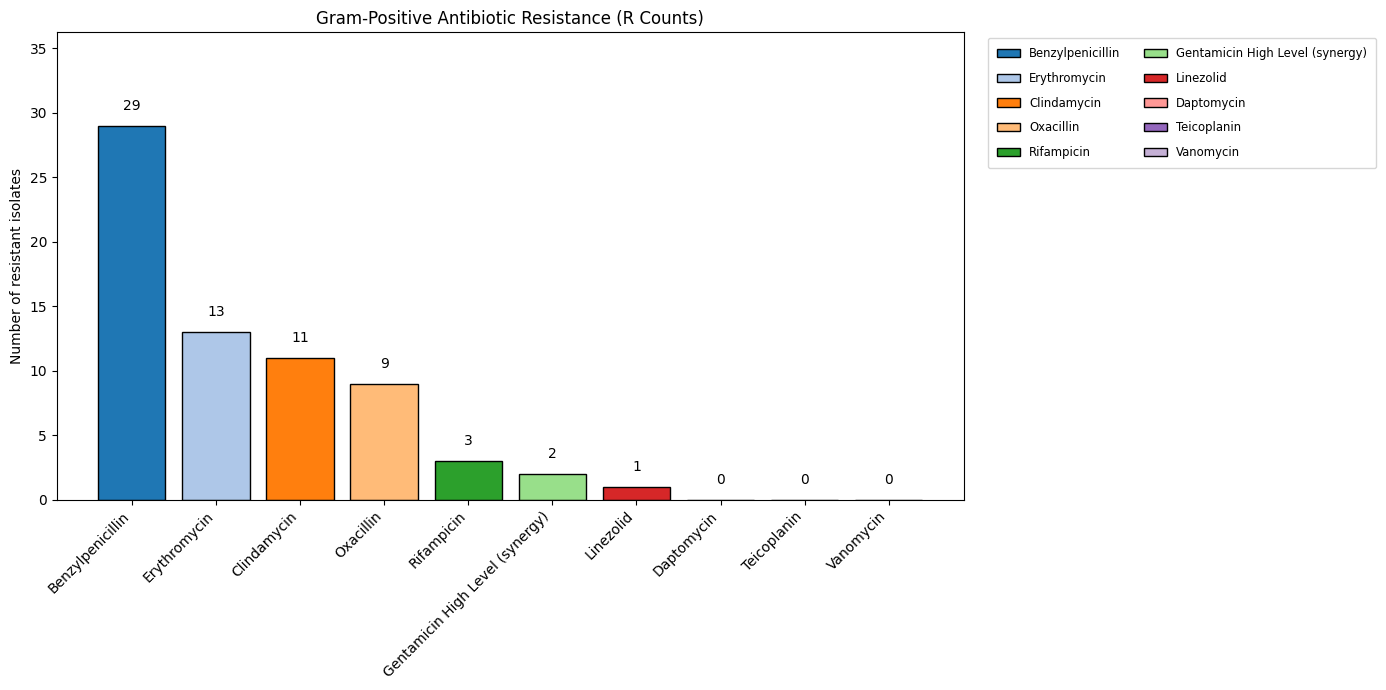

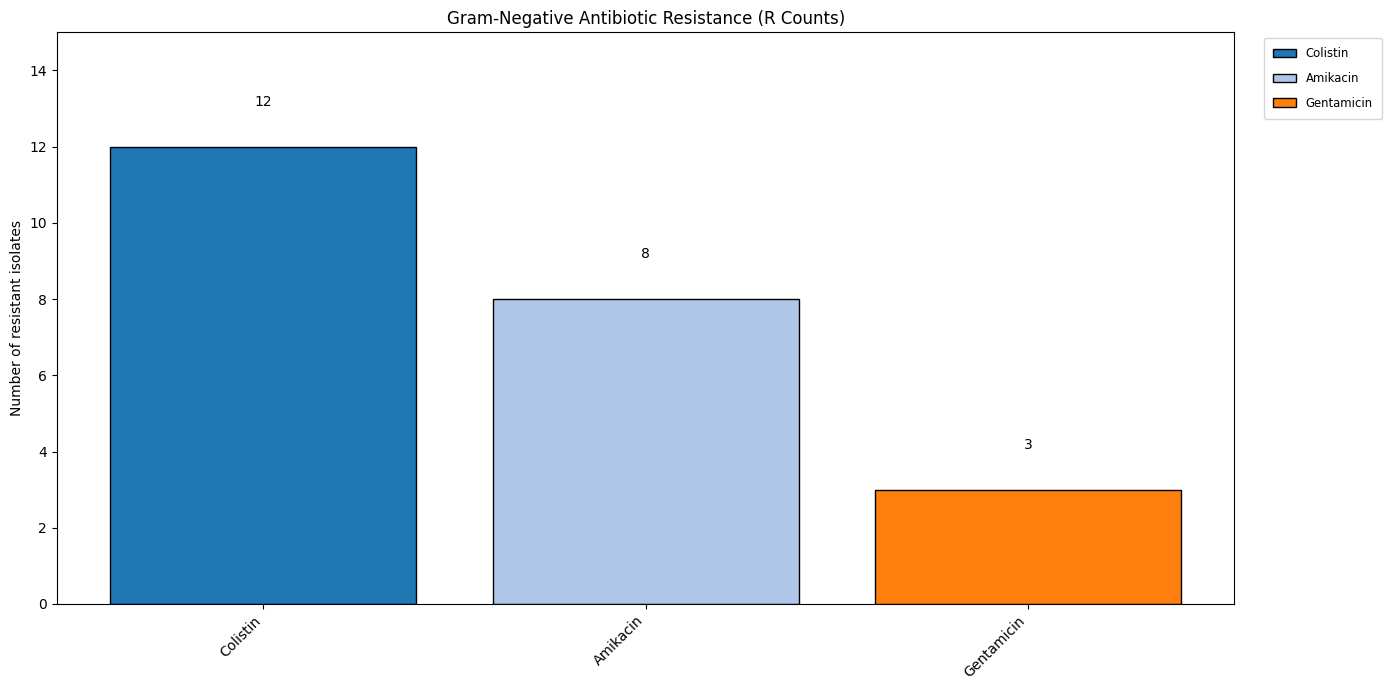

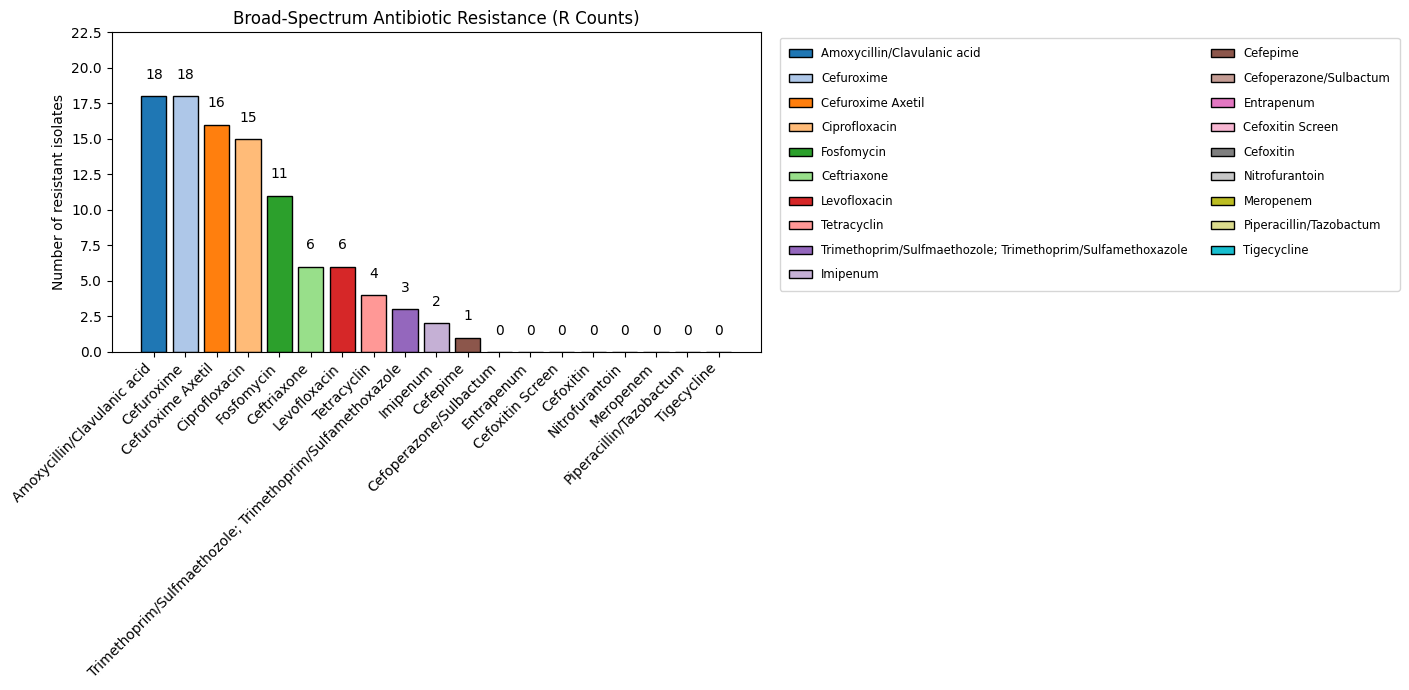

In [3]:
# === Robust corrected script to classify antibiotics and plot (fixes TypeError) ===
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap

# === Load file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === Antibiotic column header repair (same method you used) ===
start_idx = 15
end_idx   = 50

abx_name_row = df.iloc[0, start_idx:end_idx+1]
new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols
df = df.drop(index=0).reset_index(drop=True)

# === Extract antibiotic columns and clean string values (but KEEP original column names) ===
abx = df.iloc[:, start_idx:end_idx+1]
abx_clean = abx.astype(str).apply(lambda x: x.str.strip())  # keep original case for display

# === Drop known non-antibiotic test columns (Vitek 2 tests) ===
non_abx_upper = {"BETA-LACTAMASE", "INDUCIABLE CLINDAMYCIN RESISTANCE"}
cols_upper = [c.upper() for c in abx_clean.columns]
cols_to_keep = [orig for orig, up in zip(abx_clean.columns, cols_upper) if up not in non_abx_upper]
abx_clean = abx_clean[cols_to_keep]

# === Build uppercase mapping for matching, with small alias/typo corrections ===
original_cols = abx_clean.columns.tolist()
upper_cols_raw = [c.upper() for c in original_cols]

CORRECTIONS = {
    "ENTRAPENUM": "ERTAPENEM",               # Entrapenem -> Ertapenem
    "METROPENEM": "MEROPENEM",               # Metropenem -> Meropenem
    "IMIPENUM": "IMIPENEM",                  # Imipenum -> Imipenem
    "VANOMYCIN": "VANCOMYCIN",               # Vanomycin -> Vancomycin
    "TRIMETHOPRIM/SULFMAETHOZOLE": "TRIMETHOPRIM/SULFAMETHOXAZOLE",
    # Add other observed typos here if needed
}

def normalize_upper(u):
    u2 = u.strip().upper()
    u2 = u2.replace("–", "-").replace("—", "-").replace("  ", " ")
    return CORRECTIONS.get(u2, u2)

upper_cols = [normalize_upper(u) for u in upper_cols_raw]

# mapping uppercase -> list of original names (since multiple originals may map to same normalized)
upper_to_originals = {}
for up, orig in zip(upper_cols, original_cols):
    upper_to_originals.setdefault(up, []).append(orig)

# === Compute resistance counts and put index in normalized uppercase form ===
# Count 'R' in the columns (case-insensitive)
abx_values_upper = abx_clean.apply(lambda col: col.str.strip().str.upper())
res_counts = (abx_values_upper == "R").sum()   # series indexed by original column names

# Build res_counts_upper: normalized uppercase name -> sum of counts from all originals that map to it
res_counts_upper = {}
for orig_col, cnt in res_counts.items():
    up = normalize_upper(orig_col.upper())
    res_counts_upper[up] = res_counts_upper.get(up, 0) + int(cnt)

# convert to Series
res_counts_upper = pd.Series(res_counts_upper).sort_index()

# === Define final category canonical UPPER names (must match normalized uppercase keys) ===
GRAM_POS = [
    "BENZYLPENICILLIN",
    "OXACILLIN",
    "ERYTHROMYCIN",
    "CLINDAMYCIN",
    "LINEZOLID",
    "DAPTOMYCIN",
    "TEICOPLANIN",
    "VANCOMYCIN",
    "RIFAMPICIN",
    "GENTAMICIN HIGH LEVEL (SYNERGY)",
]

GRAM_NEG = [
    "AMIKACIN",
    "GENTAMICIN",
    "COLISTIN",
]

BROAD = [
    "AMOXYCILLIN/CLAVULANIC ACID",
    "PIPERACILLIN/TAZOBACTUM",
    "CEFTRIAXONE",
    "CEFEPIME",
    "CEFOPERAZONE/SULBACTUM",
    "CEFUROXIME",
    "CEFUROXIME AXETIL",
    "CEFOXITIN",
    "CEFOXITIN SCREEN",
    "ERTAPENEM",
    "IMIPENEM",
    "MEROPENEM",
    "CIPROFLOXACIN",
    "LEVOFLOXACIN",
    "TIGECYCLINE",
    "FOSFOMYCIN",
    "TETRACYCLIN",
    "NITROFURANTOIN",
    "TRIMETHOPRIM/SULFAMETHOXAZOLE",
]

# apply aliasing/canonicalisation if you want (we already normalized above)
ALIASES = {"ENTRAPENUM": "ERTAPENEM", "METROPENEM": "MEROPENEM", "IMIPENUM": "IMIPENEM", "VANOMYCIN": "VANCOMYCIN"}
GRAM_POS = [ALIASES.get(x, x) for x in GRAM_POS]
GRAM_NEG = [ALIASES.get(x, x) for x in GRAM_NEG]
BROAD    = [ALIASES.get(x, x) for x in BROAD]

# === Helper: get series of (original name -> count) for a category ===
def filter_category(cat_list):
    matched = {up: int(res_counts_upper.get(up, 0)) for up in res_counts_upper.index if up in cat_list}
    if not matched:
        return pd.Series(dtype=int)
    # for display, map each matched normalized name to the (first) original column name or a joined name
    display_map = {}
    for up, cnt in matched.items():
        originals = upper_to_originals.get(up, [up])
        # if multiple originals map to same normalized name, show them joined (use semicolon)
        display_name = "; ".join(originals)
        display_map[display_name] = cnt
    return pd.Series(display_map).sort_values(ascending=False)

# === Build category results ===
res_gp = filter_category(GRAM_POS)
res_gn = filter_category(GRAM_NEG)
res_bs = filter_category(BROAD)

# === Print diagnostics: what was found and what was unmatched ===
print("\n=== Diagnostics ===")
print(f"Total antibiotic columns processed: {len(original_cols)}")
print("Matched columns per category:")
print(f"  Gram-positive: {len(res_gp)}")
print(f"  Gram-negative: {len(res_gn)}")
print(f"  Broad-spectrum: {len(res_bs)}")

# Which normalized columns existed but were not assigned to any category:
assigned_upper = set()
for series in (res_gp, res_gn, res_bs):
    # display_map keys are original display names joined; convert back by checking upper normalized names
    for display_name in series.index:
        # split joined originals and add normalized
        for orig in display_name.split("; "):
            assigned_upper.add(normalize_upper(orig.upper()))

all_upper_from_file = set(upper_cols)
unmatched_upper = sorted([u for u in all_upper_from_file if u not in assigned_upper])
unmatched_original = []
for u in unmatched_upper:
    # collect original(s)
    origs = upper_to_originals.get(u, [u])
    unmatched_original.extend(origs)

print("\nUnmatched antibiotic columns (not assigned to GP/GN/Broad).")
if unmatched_original:
    for orig in unmatched_original:
        print(" -", orig)
else:
    print(" None — all processed columns have been assigned to a category (or have zero counts).")

# === Plot helper function ===
def plot_category(data, title):
    if data.empty:
        print(f"\nNo antibiotics found for: {title}")
        return

    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(len(data))
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(len(data))]
    bars = ax.bar(x, data.values, color=colors, edgecolor='black')

    # numeric labels above bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                h + max(1, data.max() * 0.02),
                str(int(h)),
                ha='center', va='bottom', fontsize=10)

    ax.set_ylim(0, data.max() * 1.25)
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Number of resistant isolates")

    # legend with one entry per antibiotic (colour matched)
    legend_handles = []
    for i, ab in enumerate(data.index):
        patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', label=ab)
        legend_handles.append(patch)

    ncol = 1 if len(legend_handles) <= 8 else 2
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize='small', frameon=True, ncol=ncol, labelspacing=1.0, borderpad=0.8)

    plt.tight_layout()
    plt.show()

# === Plot the three categories ===
plot_category(res_gp, "Gram-Positive Antibiotic Resistance (R Counts)")
plot_category(res_gn, "Gram-Negative Antibiotic Resistance (R Counts)")
plot_category(res_bs, "Broad-Spectrum Antibiotic Resistance (R Counts)")
